In [1]:
import numpy as np
from pathlib import Path

splits_dir = Path("../data/splits_e5large")

train = np.load(splits_dir / "train.npz", allow_pickle=True)
val   = np.load(splits_dir / "val.npz",   allow_pickle=True)

# Cast X to float32, y to int
X_train = train["X"].astype(np.float32)
y_train = train["y"].astype(int)

X_val   = val["X"].astype(np.float32)
y_val   = val["y"].astype(int)

print("X_train dtype:", X_train.dtype, "shape:", X_train.shape)
print("X_val   dtype:", X_val.dtype,   "shape:", X_val.shape)


# Feature names need allow_pickle=True
feature_columns = np.load(
    splits_dir / "feature_columns.npy",
    allow_pickle=True
).tolist()

print("Num features:", len(feature_columns))


X_train dtype: float32 shape: (350690, 1029)
X_val   dtype: float32 shape: (61887, 1029)
Num features: 1029


In [2]:
# cols_to_remove = ["isTimelineWork", "isPublicDomain", "objectEndDate", "objectBeginDate", "accessionYear"]
cols_to_remove = ["isTimelineWork", "isPublicDomain", "accessionYear"]

# Get indices of columns we want to drop
drop_indices = [feature_columns.index(col) for col in cols_to_remove]

print("Dropping indices:", drop_indices)

# Sort descending so deleting works without shifting indices
drop_indices_sorted = sorted(drop_indices, reverse=True)

for idx in drop_indices_sorted:
    X_train = np.delete(X_train, idx, axis=1)
    X_val   = np.delete(X_val,   idx, axis=1)

    # Remove from feature column names
    feature_columns.pop(idx)


Dropping indices: [3, 4, 2]


In [3]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(
    X_train, y_train,
    feature_names=feature_columns
)

val_pool = Pool(
    X_val, y_val,
    feature_names=feature_columns
)


In [17]:
model = CatBoostClassifier(
    iterations=800,          # tuned
    depth=8,                 # tuned
    learning_rate=0.08,      # tuned
    l2_leaf_reg=5,           # tuned
    border_count=64,         # tuned
    random_strength=2,       # tuned
    
    loss_function="Logloss",
    auto_class_weights="Balanced",
    eval_metric="PRAUC",
    task_type="CPU",
    verbose=100
)

model.fit(train_pool, eval_set=val_pool)


0:	learn: 0.6396039	test: 0.6391595	best: 0.6391595 (0)	total: 673ms	remaining: 8m 57s
100:	learn: 0.2225661	test: 0.2324474	best: 0.2324474 (100)	total: 1m 8s	remaining: 7m 53s
200:	learn: 0.1801475	test: 0.2022323	best: 0.2022323 (200)	total: 2m 10s	remaining: 6m 28s
300:	learn: 0.1492430	test: 0.1841627	best: 0.1841627 (300)	total: 3m 8s	remaining: 5m 12s
400:	learn: 0.1284655	test: 0.1743527	best: 0.1743527 (400)	total: 4m 7s	remaining: 4m 5s
500:	learn: 0.1132075	test: 0.1690990	best: 0.1690990 (500)	total: 5m 8s	remaining: 3m 4s
600:	learn: 0.1009578	test: 0.1643630	best: 0.1643630 (600)	total: 6m 16s	remaining: 2m 4s
700:	learn: 0.0913656	test: 0.1614798	best: 0.1614798 (700)	total: 7m 23s	remaining: 1m 2s
799:	learn: 0.0833712	test: 0.1596831	best: 0.1596831 (799)	total: 8m 25s	remaining: 0us

bestTest = 0.1596831258
bestIteration = 799



Best threshold: 0.748
Best F1: 0.8380286924849476


In [6]:
import pandas as pd

importances = model.get_feature_importance()
df_imp = pd.DataFrame({
    "feature": feature_columns,
    "importance": importances
}).sort_values("importance", ascending=False)

df_imp.head(20)

,feature,importance
1,objectEndDate,7.488980
0,objectBeginDate,4.286555
927,emb_925,1.001549
163,emb_161,0.959221
241,emb_239,0.953608
483,emb_481,0.928322
642,emb_640,0.903866
315,emb_313,0.886935
794,emb_792,0.832999
334,emb_332,0.735173


In [7]:
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "catboost_model_optimized_parameters_PRAUC_1000iter_e5large.cbm"
model.save_model(str(model_path))

print("Saved model to:", model_path)


Saved model to: models\catboost_model_optimized_parameters_PRAUC_1000iter_e5large.cbm


In [8]:
y_val_proba = model.predict_proba(X_val)[:, 1]


In [9]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 501)

best_t = 0
best_f1 = 0

for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 0.748
Best F1: 0.8380286924849476


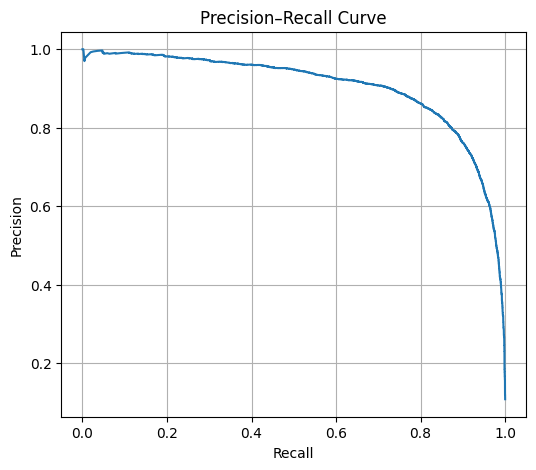

In [11]:
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()


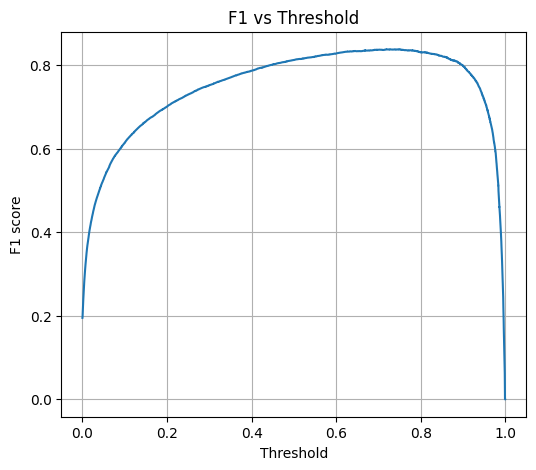

In [12]:
f1 = 2 * precision * recall / (precision + recall + 1e-9)

plt.figure(figsize=(6, 5))
plt.plot(thresholds, f1[:-1])  # f1 has one extra point
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()
